In [1]:
"""
Just for test the GPytorch functionality
"""
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # likelihood is p(y|f,x), for example y = f(x) + e, e ~ N(0,I)
model = ExactGPModel(train_x, train_y, likelihood)

In [11]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
device = "cuda"
model = model.to(device)
train_x = train_x.to(device)
train_y = train_y.to(device)
likelihood = likelihood.to(device)

model.train()
likelihood.train()

print(train_x.device)

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

cuda:0
Iter 1/50 - Loss: 0.960   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.930   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.896   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.858   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.813   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.763   lengthscale: 0.476   noise: 0.474
Iter 7/50 - Loss: 0.709   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.653   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.599   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.550   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.506   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.466   lengthscale: 0.291   noise: 0.283
Iter 13/50 - Loss: 0.430   lengthscale: 0.271   noise: 0.259
Iter 14/50 - Loss: 0.395   lengthscale: 0.254   noise: 0.236
Iter 15/50 - Loss: 0.361   lengthscale: 0.240   noise: 0.215
Iter 16/50 - Loss: 0.327   lengthscale: 0.229   noise: 0.196
Iter 17/50 - Loss: 0.294  

In [14]:
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).to(device)
    observed_pred = likelihood(model(test_x))

In [18]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

C:\ProgramData\miniconda3\envs\ai\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


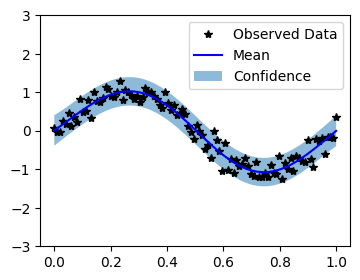

In [23]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])